In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/My Drive/FYP

# Face Parsing

## Segment out makeup


In [ ]:
os.path.dirname("face_makeup_PyTorch/test.py")

'face_makeup_PyTorch'

In [ ]:
os.chdir("face_makeup_PyTorch")

In [ ]:
import torch
import os
from model import BiSeNet
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2


def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='vis_results/parsing_map_on_im.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    return vis_parsing_anno
    # return vis_im


def evaluate(image_path='./imgs/116.jpg', cp='cp/79999_iter.pth'):

    # if not os.path.exists(respth):
    #     os.makedirs(respth)

    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    net.load_state_dict(torch.load(cp))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    with torch.no_grad():
        img = Image.open(image_path).convert('RGB')
        #image = img.resize((512, 512), Image.BILINEAR)
        image = img
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        # print(parsing)
        # print(np.unique(parsing))

        # vis_parsing_maps(image, parsing, stride=1, save_im=False, save_path=osp.join(respth, dspth))
        return parsing

In [ ]:
import cv2
import os
import numpy as np
from skimage.filters import gaussian
#from test import evaluate
import argparse
from google.colab.patches import cv2_imshow

def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, multichannel=True)

    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img

    img_out = img_out / 255.0

    mask_1 = img_out < 0
    mask_2 = img_out > 1

    img_out = img_out * (1 - mask_1)
    img_out = img_out * (1 - mask_2) + mask_2
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)


def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color      #[10, 50, 250]       # [10, 250, 10]
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    tar_hsv = cv2.cvtColor(tar_color, cv2.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

    if part == 17:
        changed = sharpen(changed)

    changed[parsing != part] = image[parsing != part]
    return changed


In [ ]:
os.listdir("..")

['t1.jpg',
 'facetools',
 'face-parsing.PyTorch',
 'colour_transfer',
 '=2.0.1',
 'fcn_pytorch.ipynb',
 'segmented face',
 'original face',
 'face_makeup_PyTorch',
 'result',
 'FYP Interim Report.gdoc',
 'girl15.csv',
 'out.png',
 'girl21.csv',
 'girl_3.csv',
 'girl.csv',
 'Full.ipynb',
 'source',
 'target',
 'result_one_dimensional',
 'result_N_dimensional',
 'FYP REPORT',
 'report',
 'Hair Color Transfer Unsegmented.ipynb',
 'Final Colour Transfer.ipynb',
 'output2.png',
 'result_lips',
 'original face OpenFace',
 'result_eyebrows',
 'result_eyes',
 'results_skin',
 'Lips Color Transfer Unsegmented.ipynb',
 'result_face',
 'chapter4.drawio']

## LIP TARGET

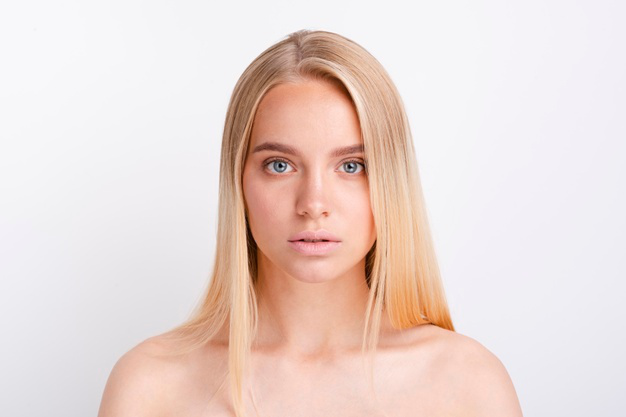

In [ ]:
from PIL import Image
# 1  face
# 11 teeth
# 12 upper lip
# 13 lower lip
# 17 hair


table = {
    'hair': 17,
    'upper_lip': 12,
    'lower_lip': 13
}


cp = 'cp/79999_iter.pth'

# image = cv2.imread(image_path)

# #image=data
image_path="../original face/image/16.jpg"
image = Image.open(image_path)
# convert image to numpy array
og_image = np.array(image)
image

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


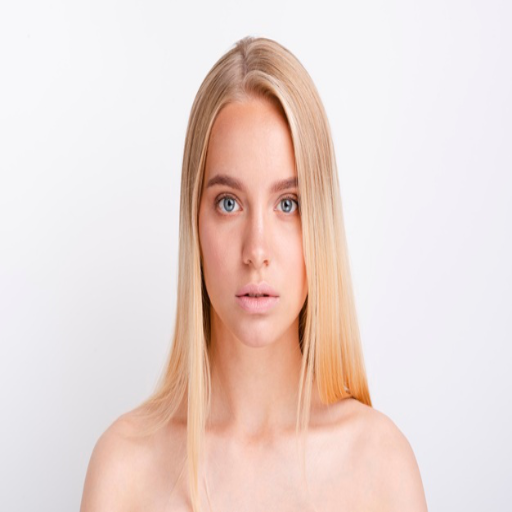

In [ ]:
ori = og_image.copy()
parsing = evaluate(image_path, cp)

print(parsing)
colors = [[230, 50, 20], [20, 70, 180], [20, 70, 180]]

cv2_imshow(cv2.resize(cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB), (512, 512)))

In [ ]:
lip_target = og_image

In [ ]:
lip_target = np.zeros((og_image.shape[0],og_image.shape[1],4))

In [ ]:
og_image.shape

(417, 626, 3)

In [ ]:
lip_target.shape

(417, 626, 4)

In [ ]:
parsing.shape

(417, 626)

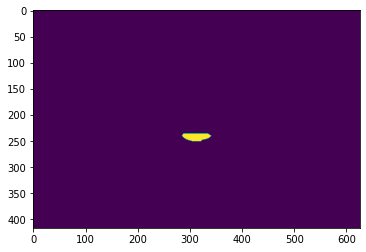

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(parsing==13)

In [ ]:
for x in range(len(parsing)):
  for y in range(len(parsing[0])):
    if (parsing[x][y]==12 or parsing[x][y]==13):
      lip_target[x][y][0]=og_image[x][y][0]
      lip_target[x][y][1]=og_image[x][y][1]
      lip_target[x][y][2]=og_image[x][y][2]
      lip_target[x][y][3]=255
    else:
      lip_target[x][y][3]=0

In [ ]:
lip_target12 = np.zeros((og_image.shape[0],og_image.shape[1],4))
lip_target13 = np.zeros((og_image.shape[0],og_image.shape[1],4))
for x in range(len(parsing)):
  for y in range(len(parsing[0])):
    if (parsing[x][y]==12):
      lip_target12[x][y][0]=og_image[x][y][0]
      lip_target12[x][y][1]=og_image[x][y][1]
      lip_target12[x][y][2]=og_image[x][y][2]
      lip_target12[x][y][3]=255
    else:
      lip_target12[x][y][3]=0

for x in range(len(parsing)):
  for y in range(len(parsing[0])):
    if (parsing[x][y]==13):
      lip_target13[x][y][0]=og_image[x][y][0]
      lip_target13[x][y][1]=og_image[x][y][1]
      lip_target13[x][y][2]=og_image[x][y][2]
      lip_target13[x][y][3]=255
    else:
      lip_target13[x][y][3]=0

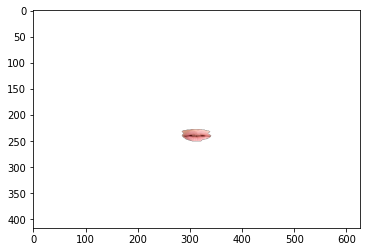

In [ ]:
plt.imshow(lip_target/255)

## LIP SOURCE

In [ ]:
from PIL import Image
# 1  face
# 11 teeth
# 12 upper lip
# 13 lower lip
# 17 hair


table = {
    'hair': 17,
    'upper_lip': 12,
    'lower_lip': 13
}


cp = 'cp/79999_iter.pth'

# image = cv2.imread(image_path)

# #image=data
# image_path="../segmented face/segmentedgirl5.png"
image_path="../original face/image/17.png"

image = Image.open(image_path)
# convert image to numpy array
og_image = np.array(image)
image

Output hidden; open in https://colab.research.google.com to view.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


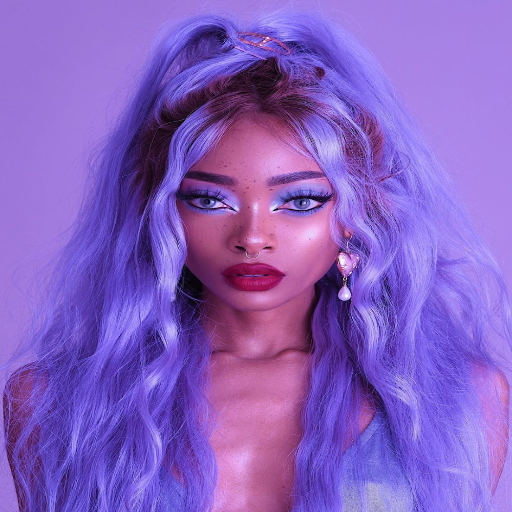

In [ ]:
ori = og_image.copy()
parsing = evaluate(image_path, cp)

print(parsing)
colors = [[230, 50, 20], [20, 70, 180], [20, 70, 180]]
cv2_imshow(cv2.resize(cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB), (512, 512)))

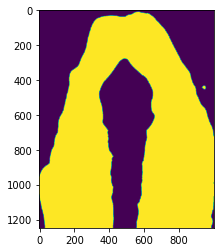

In [ ]:
plt.imshow(parsing==17)

In [ ]:
lip_source = og_image

In [ ]:
lip_source = np.zeros((og_image.shape[0],og_image.shape[1],4))

In [ ]:
for x in range((lip_source.shape[0])):
  for y in range((lip_source.shape[1])):
    if (parsing[x][y]==12 or parsing[x][y]==13):
      lip_source[x][y][0]=og_image[x][y][0]
      lip_source[x][y][1]=og_image[x][y][1]
      lip_source[x][y][2]=og_image[x][y][2]
      lip_source[x][y][3]=255
    else:
      lip_source[x][y][3]=0

In [ ]:
lip_source12 = np.zeros((og_image.shape[0],og_image.shape[1],4))
lip_source13 = np.zeros((og_image.shape[0],og_image.shape[1],4))
for x in range(len(parsing)):
  for y in range(len(parsing[0])):
    if (parsing[x][y]==12):
      lip_source12[x][y][0]=og_image[x][y][0]
      lip_source12[x][y][1]=og_image[x][y][1]
      lip_source12[x][y][2]=og_image[x][y][2]
      lip_source12[x][y][3]=255
    else:
      lip_source12[x][y][3]=0

for x in range(len(parsing)):
  for y in range(len(parsing[0])):
    if (parsing[x][y]==13):
      lip_source13[x][y][0]=og_image[x][y][0]
      lip_source13[x][y][1]=og_image[x][y][1]
      lip_source13[x][y][2]=og_image[x][y][2]
      lip_source13[x][y][3]=255
    else:
      lip_source13[x][y][3]=0

In [ ]:
lip_source.shape

(1248, 1000, 4)

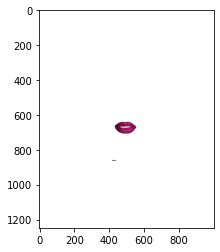

In [ ]:
plt.imshow(lip_source/255)

In [ ]:
# lip_source = lip_source.astype('float32')

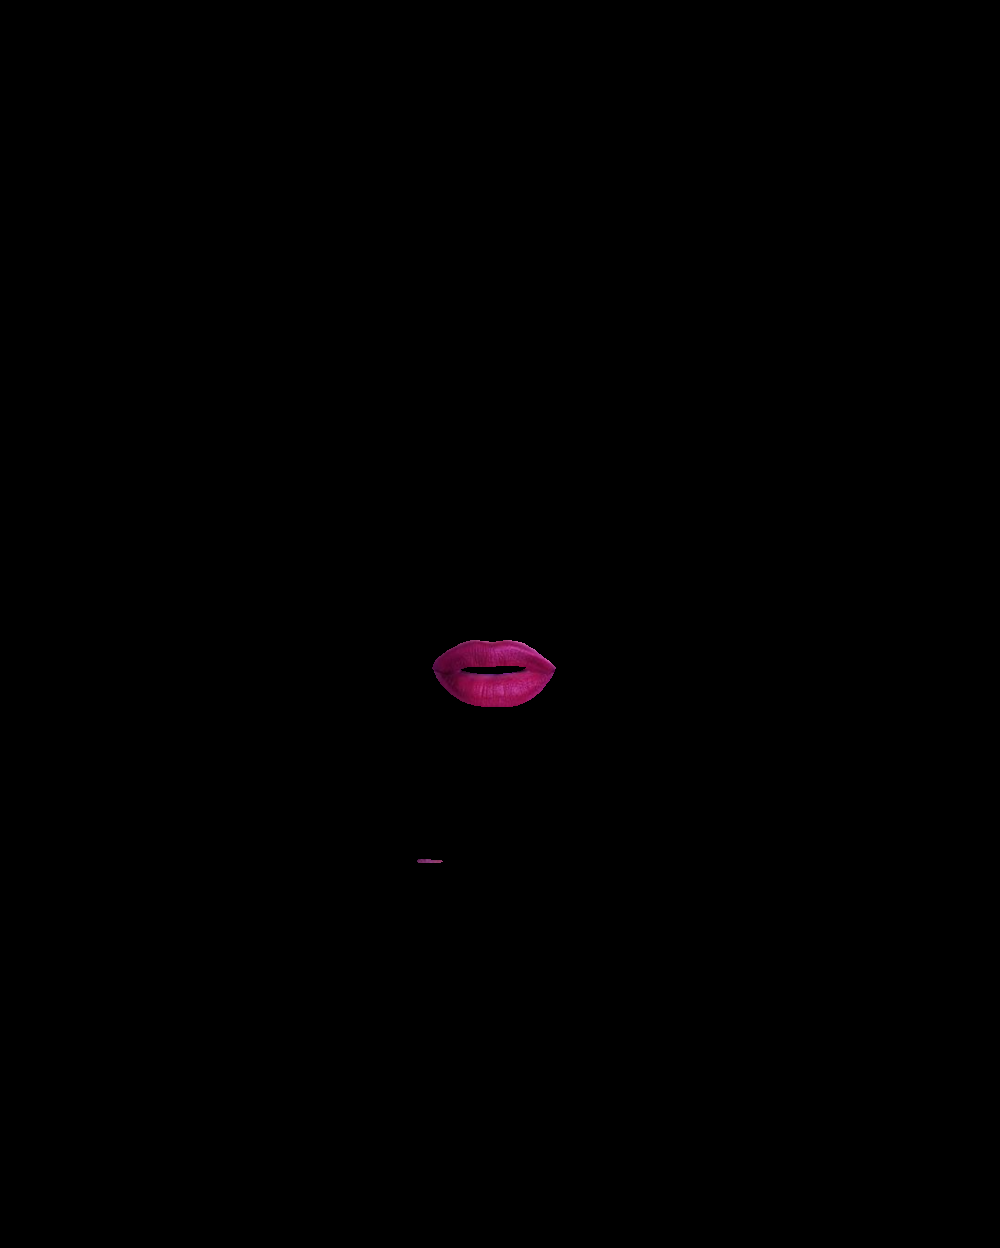

In [ ]:
cv2_imshow(cv2.cvtColor(lip_source.astype('float32'), cv2.COLOR_BGR2RGB))

## Color LIPS

In [ ]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging

from collections import OrderedDict
from itertools import combinations
from IPython.core.debugger import set_trace

logging.basicConfig(level=logging.DEBUG)

In [ ]:
def colour_transfer_IDT(I0=None,I1=None,nb_iterations=None,*args,**kwargs):
    #varargin = colour_transfer_IDT.varargin
    #nargin = colour_transfer_IDT.nargin

    if (I0.ndim != 3):
        error('pictures must have 3 dimensions')
    
    nb_channels=np.shape(I0)[2]
# colour_transfer_IDT.m:23
    ## reshape images as 3xN matrices

    D0 = np.zeros((3, np.dot(len(I0),len(I0[0]))))
    D1 = np.zeros((3, np.dot(len(I1),len(I1[0]))))
    for i in range(0,3):
        print("here")

        D0[i,:]=np.reshape(I0[:,:,i],np.dot(len(I0),len(I0[0])), order="F")
# colour_transfer_IDT.m:27
        D1[i,:]=np.reshape(I1[:,:,i],np.dot(len(I1),len(I1[0])), order="F")
# colour_transfer_IDT.m:28
    
    ## building a sequence of (almost) random projections
#
    R = np.zeros((nb_iterations,6,3))
    R[0]=np.array([[1,0,0],[0,1,0],[0,0,1],[2 / 3,2 / 3,- 1 / 3],[2 / 3,- 1 / 3,2 / 3],[- 1 / 3,2 / 3,2 / 3]])
    # colour_transfer_IDT.m:34
    for i in range(1,nb_iterations):
        R[i]=np.dot(R[0],sp.linalg.orth(np.random.randn(3,3)))

    DR=pdf_transfer(D0,D1,R)
# colour_transfer_IDT.m:41
    ## reshape the resulting 3xN matrix as an image
    IR=I0.copy()
# colour_transfer_IDT.m:44
    for i in range(0,3):
        IR[:,:,i]=np.reshape(DR[i,:],(len(IR),len(IR[0])), order="F")

    return IR

In [ ]:

def pdf_transfer(D0=None,D1=None,Rotations=None,*args,**kwargs):
    prompt=''
    eps = 1e-6
# pdf_transfer.m:34
    for it in range(0,nb_iterations):
# pdf_transfer.m:38
        #fprintf(prompt)
        R=Rotations[it]
# pdf_transfer.m:41
        print("it.    " ,it)
        nb_projs=len(R)
# pdf_transfer.m:42
        
        D0R=np.dot(R,D0)
# pdf_transfer.m:46
        D1R=np.dot(R,D1)
# pdf_transfer.m:47
        D0R_=np.zeros(D0R.shape)

        
# pdf_transfer.m:48
        for i in range(0,nb_projs):
            # if(i==3):
            #   break;
            # get the data range
            print("i         ",i)

            datamin=min(np.concatenate((D0R[i,:],D1R[i,:]))) - eps
# pdf_transfer.m:53
            datamax=max(np.concatenate((D0R[i,:],D1R[i,:]))) + eps
# pdf_transfer.m:54
            # u=np.arange(1,(301)) / (301)*(datamax - datamin) + datamin
            # u_edge=np.arange(1,(301)) / (301)*(datamax - datamin)
            print("datamax ", datamax)
            print("datamin ", datamin)
            u=(np.arange(0,(300))/(300-1))*(datamax - datamin) + datamin
            u_edge=(np.arange(-0.5,300.5,1)/(300.5-1))*(datamax - datamin)+ datamin
            print("max u_edge ", max(u_edge))
            print("min u_edge ", min(u_edge))
            print("max u ", max(u))
            print("min u ", min(u))
# pdf_transfer.m:55
            p0R,bins1,patches=plt.hist(D0R[i,:],bins = u_edge)
            print("is my bin edge same as u_edge?",u_edge == bins1)
            print("_before  pdf_transfer1D_")
# pdf_transfer.m:58
            #p1R=plt.hist(D1R[i,:],u)
            p1R,bins2,patches2=plt.hist(D1R[i,:],bins = u_edge)
# pdf_transfer.m:59
            f=pdf_transfer1D(p0R,p1R,bins1.size,bins2.size)
# pdf_transfer.m:62
            #u=np.arange(0,(300)) / (300)*(datamax - datamin) + datamin
            
            newfun = sp.interpolate.interp1d(x = u, y = f.T,kind='linear')
            
            # print("I DID IT")
            x= D0R[i,:]
            print("max x ", max(x))
            print("min x ", min(x))
            print(" after interp1d")
            newy  = newfun(x)
            D0R_[i,:]=( newy - 1) /(300-1)*(datamax-datamin) + datamin;
            # D0R_[i,:]=np.interp(D0R[i,:],edges[1:],f.T)/(300-1)*(datamax-datamin) + datamin;
            # print("))))")
            # D0R_[i,:]=np.dot((interp1(u,f.T,D0R[i,:]) - 1) / (300 - 1),(datamax - datamin)) + datamin
# pdf_transfer.m:65
        # print("DO ",D0.shape)
        # print("D0R_ ", D0R_.shape)
        # print("D0R ", D0R_.shape)
        # print("R ",R.shape)
        lin, residuals, rank, s = np.linalg.lstsq(R,(D0R_ - D0R))
        print("lin", lin.shape)
        D0=relaxation * lin + D0
# pdf_transfer.m:68
    
    
    DR=D0.copy()
# pdf_transfer.m:74
    return DR
    

    
    # 1D - PDF Transfer
    
def pdf_transfer1D(pX=None,pY=None,bins=None,bins2=None,*args,**kwargs):
    #varargin = pdf_transfer1D.varargin
    #nargin = pdf_transfer1D.nargin
    print("in pdf_transfer1D")
    nbins=bins
    #print(pX)
# pdf_transfer.m:82
    eps=[1e-06]
    x = pX+eps
    PX=x.cumsum()
# pdf_transfer.m:86
    PX=PX / PX[-1]
# pdf_transfer.m:87
    y = pY + eps
    PY=y.cumsum()
# pdf_transfer.m:89
    PY=PY / PY[-1]
    print("PX min ", min(PX))
    print("PX max ", max(PX))

    print("PY min ", min(PY))
    print("PY max ", max(PY))

    f=sp.interpolate.interp1d(x = PY, y=np.arange(0,nbins-1),kind='linear',fill_value="extrapolate")
    b=f(PX)
    print(b.size)
    #f=interp1(PY,np.arange(0,nbins - 1),PX,'linear')
# pdf_transfer.m:94
    b[PX <= PY[0]]=0
# pdf_transfer.m:95
    b[PX >= PY[-1]]=nbins - 1
# pdf_transfer.m:96
    if sum(np.isnan(b)) > 0:
        error('colour_transfer:pdf_transfer:NaN','pdf_transfer has generated NaN values')
    print("out pdf_transfer1D")
    
    return b
    


In [ ]:
# I1 = plt.imread('purplehair.jpeg')/255
# #I1 = plt.imread('hair.jpg')/255
I1 = lip_source/255
I0 = lip_target/255
# I1 = hair_source
# I0 = hair_target
relaxation=1
nb_iterations=10

 55.581585645675  
 +65.47942423820496  
  +56.21955966949  
  +64.668147802352  
  +77.3574860095  
   +102.1105563640594

here
here
here
it.     0
i          0
datamax  1.000001
datamin  -1e-06
max u_edge  1.000001
min u_edge  -0.0016704524207011684
max u  1.000001
min u  -1e-06
is my bin edge same as u_edge? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


datamax  1e-06
datamin  -1.153270342799375
max u_edge  9.999999999177334e-07
min u_edge  -1.155195670583681
max u  9.999999999177334e-07
min u  -1.153270342799375
is my bin edge same as u_edge? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  T

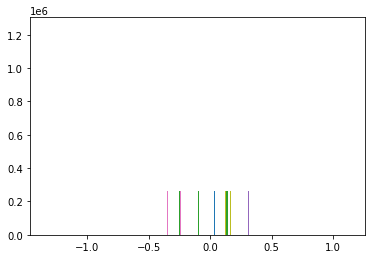

In [ ]:
import time
start_time = time.time()
IR_idt=colour_transfer_IDT(I0,I1,10)
print("--- %s seconds ---" % (time.time() - start_time))

115.97633862495422  

135.01590132713318

114.940601110  
132.3352737426757  
155.81372284889  
204.6689949035644

here
here
here
it.     0
i          0
datamax  1.000001
datamin  -1e-06
max u_edge  1.000001
min u_edge  -0.0016704524207011684
max u  1.000001
min u  -1e-06
is my bin edge same as u_edge? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Streaming output truncated to the last 5000 lines.
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True


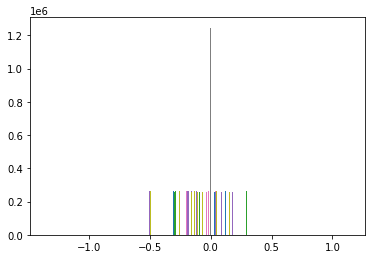

In [ ]:
I112 = lip_source12/255
I012 = lip_target12/255

relaxation=1
nb_iterations=10

start_time = time.time()
IR_idt12=colour_transfer_IDT(I012,I112,10)

I113 = lip_source13/255
I013 = lip_target13/255

relaxation=1
nb_iterations=10
IR_idt13=colour_transfer_IDT(I013,I113,10)
print("--- %s seconds ---" % (time.time() - start_time))

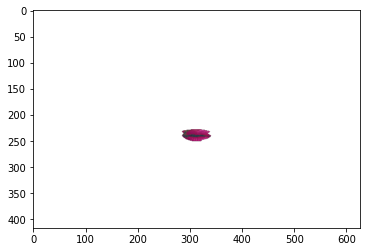

In [ ]:
plt.imshow(IR_idt)

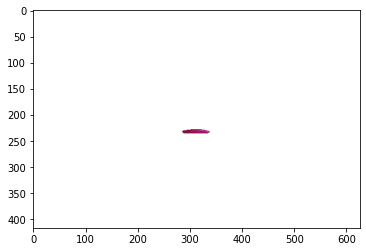

In [ ]:
plt.imshow(IR_idt12)

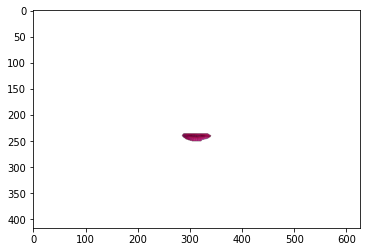

In [ ]:
plt.imshow(IR_idt13)

In [ ]:
image_path="../original face/image/16.jpg"

In [ ]:
cp2= IR_idt

In [ ]:
type(cp2[0][0][0])

numpy.float64

In [ ]:
og = np.asarray(plt.imread(image_path),dtype=np.float64)

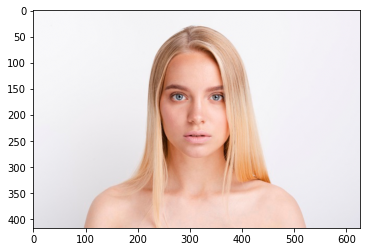

In [ ]:
og = og/255
plt.imshow(og)

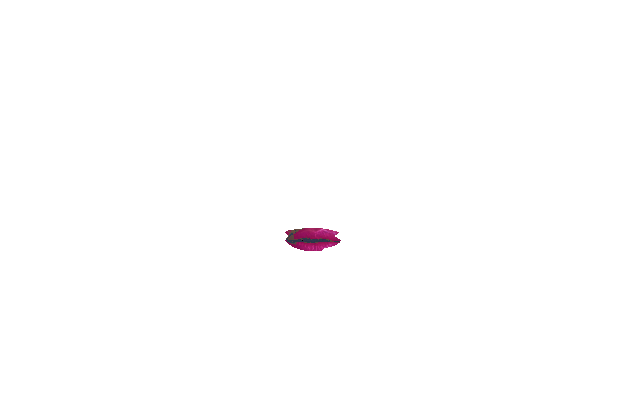

In [ ]:
from skimage import img_as_ubyte

img2 = img_as_ubyte(cp2/np.max(cp2))
Image.fromarray(img2)

In [ ]:
from PIL import Image
import numpy as np
# load the image
#image = cv2.imread(image_path)

og2 = og
cp2= IR_idt
for x in range(IR_idt.shape[0]):
  for y in range(IR_idt.shape[1]):
    if (cp2[x,y,3]==1.0):
      og2[x,y,0]=cp2[x,y,0]
      og2[x,y,1]=cp2[x,y,1]
      og2[x,y,2]=cp2[x,y,2]
      #og2[x,y,3]=1
      # new[x][y][3]=255

In [ ]:
np.max(og2)

1.0

In [ ]:
from skimage import img_as_ubyte

img = img_as_ubyte(og2/np.max(og2))

In [ ]:
#LIPS
img2 = Image.fromarray(img)

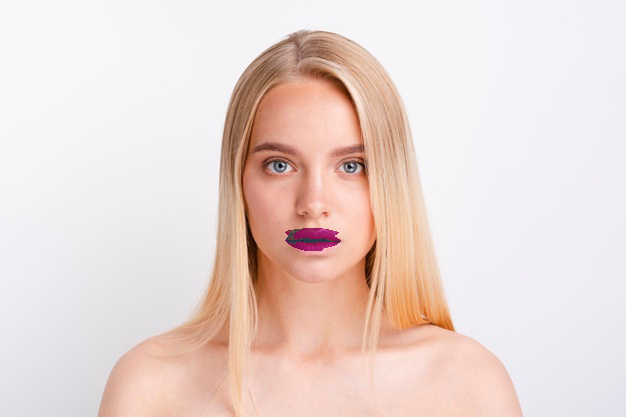

In [ ]:
img2

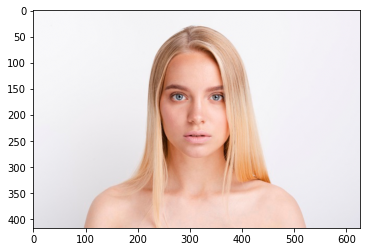

In [ ]:
og = np.asarray(plt.imread(image_path),dtype=np.float64)
og = og/255
og2 = og
plt.imshow(og2)

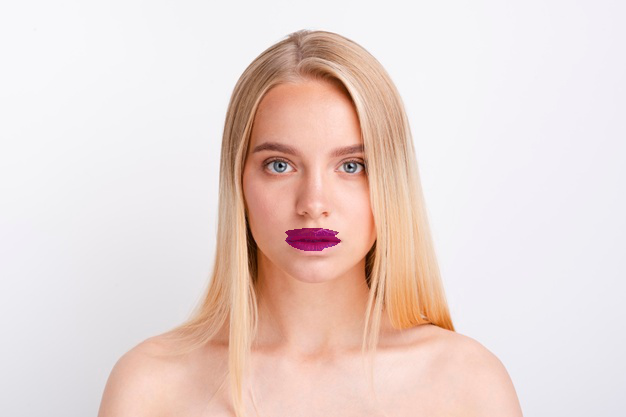

In [ ]:
#BOTH LIPS
from PIL import Image
import numpy as np
from skimage import img_as_ubyte

cp12= IR_idt12
cp13 = IR_idt13
for x in range(IR_idt12.shape[0]):
  for y in range(IR_idt12.shape[1]):
    if (cp12[x,y,3]==1.0):
      og2[x,y,0]=cp12[x,y,0]
      og2[x,y,1]=cp12[x,y,1]
      og2[x,y,2]=cp12[x,y,2]
    if (cp13[x,y,3]==1.0):
      og2[x,y,0]=cp13[x,y,0]
      og2[x,y,1]=cp13[x,y,1]
      og2[x,y,2]=cp13[x,y,2]


img = img_as_ubyte(og2/np.max(og2))
img1213= Image.fromarray(img)
img1213

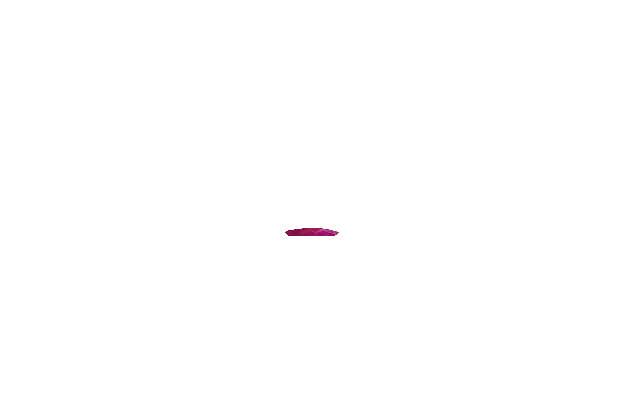

In [ ]:
from skimage import img_as_ubyte

Image.fromarray( img_as_ubyte(cp12/np.max(cp12)))

## Result Saving

In [ ]:
img2.save("../result_lips/11_16_result.jpg")

In [ ]:
img1213.save("../result_lips/11_16_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl_2_16_result.jpg")

In [ ]:
img1213.save("../result_lips/girl_2_16_result1213.jpg")

In [ ]:
img2.save("../result_lips/girl18_16_result.jpg")

In [ ]:
img1213.save("../result_lips/girl18_16_result1213.jpg")

In [ ]:
img2.save("../result_lips/girl18_girl21_result.jpg")

In [ ]:
img1213.save("../result_lips/girl18_girl21_result1213.jpg")

In [ ]:
img2.save("../result_lips/11_girl21_result.jpg")

In [ ]:
img1213.save("../result_lips/11_girl21_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl_2_girl21_result.jpg")

In [ ]:
img1213.save("../result_lips/girl_2_girl21_result1213.jpg")

In [ ]:
img2.save("../result_lips/17_girl21_result.jpg")

In [ ]:
img1213.save("../result_lips/17_girl21_result1213.jpg")

In [ ]:
img2.save("../result_lips/girl8_girl21_result.jpg")

In [ ]:
img1213.save("../result_lips/girl8_girl21_result1213.jpg")

In [ ]:
img2.save("../result_lips/girl16_girl21_result.jpg")

In [ ]:
img2.save("../result_lips/girl18_13_result.jpg")

In [ ]:
img1213.save("../result_lips/girl18_13_result1213.jpg")

In [ ]:
img2.save("../result_lips/11_13_result.jpg")

In [ ]:
img1213.save("../result_lips/11_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl_2_13_result.jpg")

In [ ]:
img1213.save("../result_lips/girl_2_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/17_13_result.jpg")

In [ ]:
img1213.save("../result_lips/17_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl14_13_result.jpg")

In [ ]:
img1213.save("../result_lips/girl14_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl19_13_result.jpg")

In [ ]:
img1213.save("../result_lips/girl19_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl17_13_result.jpg")

In [ ]:
img1213.save("../result_lips/girl17_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/7_13_result.jpg")

In [ ]:
img1213.save("../result_lips/7_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/1_13_result.jpg")

In [ ]:
img1213.save("../result_lips/1_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl9_13_result.jpg")

In [ ]:
img1213.save("../result_lips/girl9_13_result_1213.jpg")

In [ ]:
img2.save("../result_lips/girl9_girl21_result.jpg")

In [ ]:
img1213.save("../result_lips/girl9_girl21_result_1213.jpg")

In [ ]:
img1213.save("../result_lips/17_16_result_1213.jpg")

In [ ]:
img2.save("../result_lips/17_16_result.jpg")

# Open Face

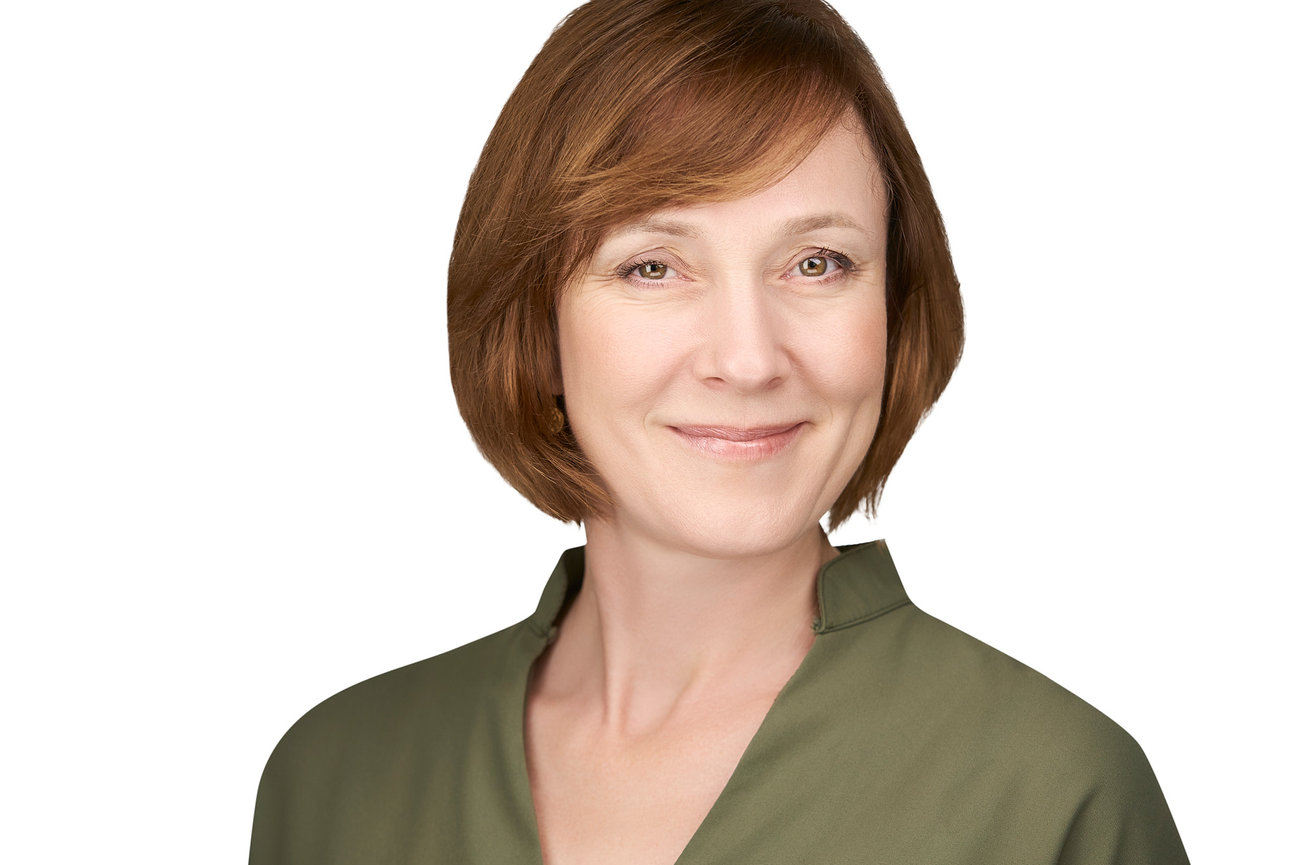

In [ ]:
 import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
image_path = "original face/girl_3.jpg"
image_path_target =  "original face/image/1.jpg"
cv2_imshow(cv2.imread(image_path))
og_csv = 'original face OpenFace/girl_3.csv'
tg_csv = 'original face OpenFace/1.csv'

## SOURCE LIPS

In [ ]:
# Read CSV
csv_details = pd.read_csv(og_csv, delimiter = ", ")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
upperlip=""
for i in range(48,55):
  upperlip+=(str(i)+",")
for i in range(60,65):
  upperlip+=(str(i)+",")

upperlip

'48,49,50,51,52,53,54,60,61,62,63,64,'

In [ ]:
bottomlip="48,"

for i in range(54,60):
  bottomlip+=(str(i)+",")
for i in range(64,68):
  bottomlip+=(str(i)+",")

bottomlip

'48,54,55,56,57,58,59,64,65,66,67,'

In [ ]:
#cheeks_list = []
#k = 0
source_upper_lip = ()
for i in [48,49,50,51,52,53,54,64,63,62,61,60,48]:
#for i in [47,13]:
  # csv_details.iloc[0]['face']
  t = (csv_details.iloc[0]["x_"+str(i)], csv_details.iloc[0]["y_"+str(i)])
  t1 = (int(csv_details.iloc[0]["x_"+str(i)]), int(csv_details.iloc[0]["y_"+str(i)]))
  source_upper_lip = source_upper_lip + t1
  ##cheeks_list.append(t)
  #k = k+1

source_upper_lip

(658,
 424,
 693,
 422,
 723,
 422,
 741,
 426,
 762,
 421,
 788,
 421,
 812,
 421,
 803,
 425,
 762,
 433,
 741,
 437,
 721,
 435,
 668,
 427,
 658,
 424)

In [ ]:
#cheeks_list = []
#k = 0
source_bottom_lip = ()
for i in [48,60,67,66,65,64,54,55,56,57,58,59,48]:
#for i in [0,49]:
  # csv_details.iloc[0]['face']
  t = (csv_details.iloc[0]["x_"+str(i)], csv_details.iloc[0]["y_"+str(i)])
  t1 = (int(csv_details.iloc[0]["x_"+str(i)]), int(csv_details.iloc[0]["y_"+str(i)]))
  source_bottom_lip = source_bottom_lip + t1
  #cheeks_list.append(t)
  #k = k+1

#cheeks_list

In [ ]:
import numpy
from PIL import Image, ImageDraw

#################### Upper Lip ####################
# read image as RGB and add alpha (transparency)
im = Image.open(image_path).convert("RGBA")

# convert to numpy (for convenience)
imArray = numpy.asarray(im)

# create mask
polygon = source_upper_lip
maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]),0)
ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
#ImageDraw.Draw(maskIm).chord(source_left_cheek, start=0,end=360,outline=1, fill=1)
mask = numpy.array(maskIm)

# assemble new image (uint8: 0-255)
source_upper_lip_newImArray = numpy.empty(imArray.shape,dtype='uint8')

# colors (three first columns, RGB)
source_upper_lip_newImArray[:,:,:3] = imArray[:,:,:3]

# transparency (4th column)
source_upper_lip_newImArray[:,:,3] = mask*255

#################### Bottom Lip ####################
im = Image.open(image_path).convert("RGBA")

# convert to numpy (for convenience)
imArray = numpy.asarray(im)

# create mask
polygon = source_bottom_lip
maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]),0)
ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
#ImageDraw.Draw(maskIm).chord(source_right_cheek, start=0,end=360,outline=1, fill=1)
mask = numpy.array(maskIm)

# assemble new image (uint8: 0-255)
source_bottom_lip_newImArray = numpy.empty(imArray.shape,dtype='uint8')

# colors (three first columns, RGB)
source_bottom_lip_newImArray[:,:,:3] = imArray[:,:,:3]

# transparency (4th column)
source_bottom_lip_newImArray[:,:,3] = mask*255

In [ ]:
source_upper_lip_newImArray

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [ ]:

for x in range(len(source_upper_lip_newImArray)):
  for y in range(len(source_upper_lip_newImArray[0])):
    if (source_upper_lip_newImArray[x,y,3]==0):
      #print("true")
      source_upper_lip_newImArray[x,y,0]=0
      source_upper_lip_newImArray[x,y,1]=0
      source_upper_lip_newImArray[x,y,2]=0
      source_upper_lip_newImArray[x,y,3]=0
   

for x in range(len(source_bottom_lip_newImArray)):
  for y in range(len(source_bottom_lip_newImArray[0])):
    if (source_bottom_lip_newImArray[x,y,3]==0):
      source_bottom_lip_newImArray[x,y,0]=0
      source_bottom_lip_newImArray[x,y,1]=0
      source_bottom_lip_newImArray[x,y,2]=0
      source_bottom_lip_newImArray[x,y,3]=0

In [ ]:
# back to Image from numpy
source_upper_lip_EXT = Image.fromarray(source_upper_lip_newImArray, "RGBA")
# back to Image from numpy
source_bottom_lip_EXT = Image.fromarray(source_bottom_lip_newImArray, "RGBA")
source_upper_lip_EXT_ARRAY = numpy.asarray(source_upper_lip_EXT)
source_bottom_lip_EXT_ARRAY = numpy.asarray(source_bottom_lip_EXT)

## TARGET LIPS

In [ ]:
# Read CSV
csv_details = pd.read_csv(tg_csv, delimiter = ", ")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
#cheeks_list = []
#k = 0
target_upper_lip = ()
for i in [48,49,50,51,52,53,54,64,63,62,61,60,48]:
#for i in [47,13]:
  # csv_details.iloc[0]['face']
  t = (csv_details.iloc[0]["x_"+str(i)], csv_details.iloc[0]["y_"+str(i)])
  t1 = (int(csv_details.iloc[0]["x_"+str(i)]), int(csv_details.iloc[0]["y_"+str(i)]))
  target_upper_lip = target_upper_lip + t1
  ##cheeks_list.append(t)
  #k = k+1

target_upper_lip

(315,
 378,
 349,
 373,
 381,
 378,
 401,
 388,
 425,
 392,
 455,
 407,
 479,
 428,
 468,
 426,
 422,
 406,
 398,
 401,
 377,
 393,
 324,
 383,
 315,
 378)

In [ ]:
#cheeks_list = []
#k = 0
target_bottom_lip = ()
for i in [48,60,67,66,65,64,54,55,56,57,58,59,48]:
#for i in [0,49]:
  # csv_details.iloc[0]['face']
  t = (csv_details.iloc[0]["x_"+str(i)], csv_details.iloc[0]["y_"+str(i)])
  t1 = (int(csv_details.iloc[0]["x_"+str(i)]), int(csv_details.iloc[0]["y_"+str(i)]))
  target_bottom_lip = target_bottom_lip + t1
  #cheeks_list.append(t)
  #k = k+1

#cheeks_list

In [ ]:
import numpy
from PIL import Image, ImageDraw

#################### Upper Lip ####################
# read image as RGB and add alpha (transparency)
im = Image.open(image_path_target).convert("RGBA")

# convert to numpy (for convenience)
imArray = numpy.asarray(im)

# create mask
polygon = target_upper_lip
maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]),0)
ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
#ImageDraw.Draw(maskIm).chord(source_left_cheek, start=0,end=360,outline=1, fill=1)
mask = numpy.array(maskIm)

# assemble new image (uint8: 0-255)
target_upper_lip_newImArray = numpy.empty(imArray.shape,dtype='uint8')

# colors (three first columns, RGB)
target_upper_lip_newImArray[:,:,:3] = imArray[:,:,:3]

# transparency (4th column)
target_upper_lip_newImArray[:,:,3] = mask*255

#################### Bottom Lip ####################
im = Image.open(image_path_target).convert("RGBA")

# convert to numpy (for convenience)
imArray = numpy.asarray(im)

# create mask
polygon = target_bottom_lip
maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]),0)
ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
#ImageDraw.Draw(maskIm).chord(source_right_cheek, start=0,end=360,outline=1, fill=1)
mask = numpy.array(maskIm)

# assemble new image (uint8: 0-255)
target_bottom_lip_newImArray = numpy.empty(imArray.shape,dtype='uint8')

# colors (three first columns, RGB)
target_bottom_lip_newImArray[:,:,:3] = imArray[:,:,:3]

# transparency (4th column)
target_bottom_lip_newImArray[:,:,3] = mask*255

In [ ]:

for x in range(len(target_upper_lip_newImArray)):
  for y in range(len(target_upper_lip_newImArray[0])):
    if (target_upper_lip_newImArray[x][y][3]==0):
      target_upper_lip_newImArray[x][y][0]=0
      target_upper_lip_newImArray[x][y][1]=0
      target_upper_lip_newImArray[x][y][2]=0
      target_upper_lip_newImArray[x][y][3]=0
   

for x in range(len(target_bottom_lip_newImArray)):
  for y in range(len(target_bottom_lip_newImArray[0])):
    if (target_bottom_lip_newImArray[x][y][3]==0):
      target_bottom_lip_newImArray[x][y][0]=0
      target_bottom_lip_newImArray[x][y][1]=0
      target_bottom_lip_newImArray[x][y][2]=0
      target_bottom_lip_newImArray[x][y][3]=0

In [ ]:
# back to Image from numpy
target_upper_lip_EXT = Image.fromarray(target_upper_lip_newImArray, "RGBA")
# back to Image from numpy
target_bottom_lip_EXT = Image.fromarray(target_bottom_lip_newImArray, "RGBA")
target_upper_lip_EXT_ARRAY = numpy.asarray(target_upper_lip_EXT)
target_bottom_lip_EXT_ARRAY = numpy.asarray(target_bottom_lip_EXT)

## Color LIPS

In [ ]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging

from collections import OrderedDict
from itertools import combinations
from IPython.core.debugger import set_trace

logging.basicConfig(level=logging.DEBUG)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [ ]:
def colour_transfer_IDT(I0=None,I1=None,nb_iterations=None,*args,**kwargs):
    #varargin = colour_transfer_IDT.varargin
    #nargin = colour_transfer_IDT.nargin

    if (I0.ndim != 3):
        error('pictures must have 3 dimensions')
    
    nb_channels=np.shape(I0)[2]
# colour_transfer_IDT.m:23
    ## reshape images as 3xN matrices

    D0 = np.zeros((3, np.dot(len(I0),len(I0[0]))))
    D1 = np.zeros((3, np.dot(len(I1),len(I1[0]))))
    for i in range(0,3):
        print("here")

        D0[i,:]=np.reshape(I0[:,:,i],np.dot(len(I0),len(I0[0])), order="F")
# colour_transfer_IDT.m:27
        D1[i,:]=np.reshape(I1[:,:,i],np.dot(len(I1),len(I1[0])), order="F")
# colour_transfer_IDT.m:28
    
    ## building a sequence of (almost) random projections
#
    R = np.zeros((nb_iterations,6,3))
    R[0]=np.array([[1,0,0],[0,1,0],[0,0,1],[2 / 3,2 / 3,- 1 / 3],[2 / 3,- 1 / 3,2 / 3],[- 1 / 3,2 / 3,2 / 3]])
    # colour_transfer_IDT.m:34
    for i in range(1,nb_iterations):
        R[i]=np.dot(R[0],sp.linalg.orth(np.random.randn(3,3)))

    DR=pdf_transfer(D0,D1,R)
# colour_transfer_IDT.m:41
    ## reshape the resulting 3xN matrix as an image
    IR=I0.copy()
# colour_transfer_IDT.m:44
    for i in range(0,3):
        IR[:,:,i]=np.reshape(DR[i,:],(len(IR),len(IR[0])), order="F")

    return IR

In [ ]:

def pdf_transfer(D0=None,D1=None,Rotations=None,*args,**kwargs):
    prompt=''
    eps = 1e-6
# pdf_transfer.m:34
    for it in range(0,nb_iterations):
# pdf_transfer.m:38
        #fprintf(prompt)
        R=Rotations[it]
# pdf_transfer.m:41
        print("it.    " ,it)
        nb_projs=len(R)
# pdf_transfer.m:42
        
        D0R=np.dot(R,D0)
# pdf_transfer.m:46
        D1R=np.dot(R,D1)
# pdf_transfer.m:47
        D0R_=np.zeros(D0R.shape)

        
# pdf_transfer.m:48
        for i in range(0,nb_projs):
            # if(i==3):
            #   break;
            # get the data range
            print("i         ",i)

            datamin=min(np.concatenate((D0R[i,:],D1R[i,:]))) - eps
# pdf_transfer.m:53
            datamax=max(np.concatenate((D0R[i,:],D1R[i,:]))) + eps
# pdf_transfer.m:54
            # u=np.arange(1,(301)) / (301)*(datamax - datamin) + datamin
            # u_edge=np.arange(1,(301)) / (301)*(datamax - datamin)
            print("datamax ", datamax)
            print("datamin ", datamin)
            u=(np.arange(0,(300))/(300-1))*(datamax - datamin) + datamin
            u_edge=(np.arange(-0.5,300.5,1)/(300.5-1))*(datamax - datamin)+ datamin
            print("max u_edge ", max(u_edge))
            print("min u_edge ", min(u_edge))
            print("max u ", max(u))
            print("min u ", min(u))
# pdf_transfer.m:55
            p0R,bins1,patches=plt.hist(D0R[i,:],bins = u_edge)
            print("is my bin edge same as u_edge?",u_edge == bins1)
            print("_before  pdf_transfer1D_")
# pdf_transfer.m:58
            #p1R=plt.hist(D1R[i,:],u)
            p1R,bins2,patches2=plt.hist(D1R[i,:],bins = u_edge)
# pdf_transfer.m:59
            f=pdf_transfer1D(p0R,p1R,bins1.size,bins2.size)
# pdf_transfer.m:62
            #u=np.arange(0,(300)) / (300)*(datamax - datamin) + datamin
            
            newfun = sp.interpolate.interp1d(x = u, y = f.T,kind='linear')
            
            # print("I DID IT")
            x= D0R[i,:]
            print("max x ", max(x))
            print("min x ", min(x))
            print(" after interp1d")
            newy  = newfun(x)
            D0R_[i,:]=( newy - 1) /(300-1)*(datamax-datamin) + datamin;
            # D0R_[i,:]=np.interp(D0R[i,:],edges[1:],f.T)/(300-1)*(datamax-datamin) + datamin;
            # print("))))")
            # D0R_[i,:]=np.dot((interp1(u,f.T,D0R[i,:]) - 1) / (300 - 1),(datamax - datamin)) + datamin
# pdf_transfer.m:65
        # print("DO ",D0.shape)
        # print("D0R_ ", D0R_.shape)
        # print("D0R ", D0R_.shape)
        # print("R ",R.shape)
        lin, residuals, rank, s = np.linalg.lstsq(R,(D0R_ - D0R))
        print("lin", lin.shape)
        D0=relaxation * lin + D0
# pdf_transfer.m:68
    
    
    DR=D0.copy()
# pdf_transfer.m:74
    return DR
    

    
    # 1D - PDF Transfer
    
def pdf_transfer1D(pX=None,pY=None,bins=None,bins2=None,*args,**kwargs):
    #varargin = pdf_transfer1D.varargin
    #nargin = pdf_transfer1D.nargin
    print("in pdf_transfer1D")
    nbins=bins
    #print(pX)
# pdf_transfer.m:82
    eps=[1e-06]
    x = pX+eps
    PX=x.cumsum()
# pdf_transfer.m:86
    PX=PX / PX[-1]
# pdf_transfer.m:87
    y = pY + eps
    PY=y.cumsum()
# pdf_transfer.m:89
    PY=PY / PY[-1]
    print("PX min ", min(PX))
    print("PX max ", max(PX))

    print("PY min ", min(PY))
    print("PY max ", max(PY))

    f=sp.interpolate.interp1d(x = PY, y=np.arange(0,nbins-1),kind='linear',fill_value="extrapolate")
    b=f(PX)
    print(b.size)
    #f=interp1(PY,np.arange(0,nbins - 1),PX,'linear')
# pdf_transfer.m:94
    b[PX <= PY[0]]=0
# pdf_transfer.m:95
    b[PX >= PY[-1]]=nbins - 1
# pdf_transfer.m:96
    if sum(np.isnan(b)) > 0:
        error('colour_transfer:pdf_transfer:NaN','pdf_transfer has generated NaN values')
    print("out pdf_transfer1D")
    
    return b
    


 142.08134722709656+93.5395860671997+130.79228901863098+111.2780997753143+82+91.99046635627747 

here
here
here
it.     0
i          0
datamax  1.000001
datamin  -1e-06
max u_edge  1.000001
min u_edge  -0.0016704524207011684
max u  1.000001
min u  -1e-06
is my bin edge same as u_edge? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Streaming output truncated to the last 5000 lines.
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True


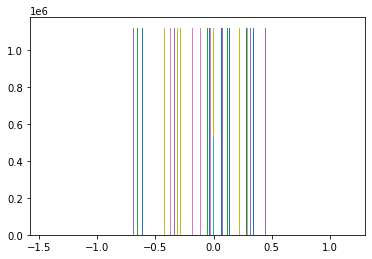

In [ ]:
import time
I012 = source_upper_lip_EXT_ARRAY/255
I112 = target_upper_lip_EXT_ARRAY/255

relaxation=1
nb_iterations=10

start_time = time.time()
IR_idt12=colour_transfer_IDT(I012,I112,10)

I013 = source_bottom_lip_EXT_ARRAY/255
I113 = target_bottom_lip_EXT_ARRAY/255

relaxation=1
nb_iterations=10
IR_idt13=colour_transfer_IDT(I013,I113,10)
print("--- %s seconds ---" % (time.time() - start_time))

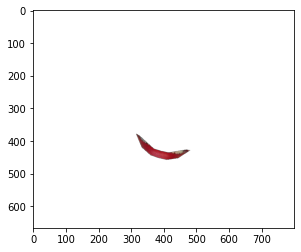

In [ ]:
plt.imshow(I113)

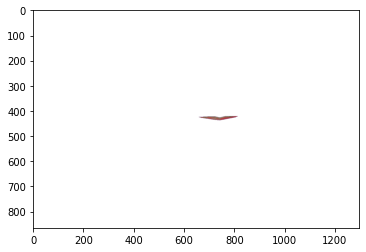

In [ ]:
plt.imshow(IR_idt12)

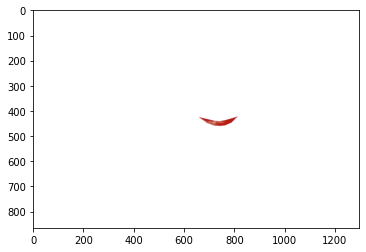

In [ ]:
plt.imshow(IR_idt13)

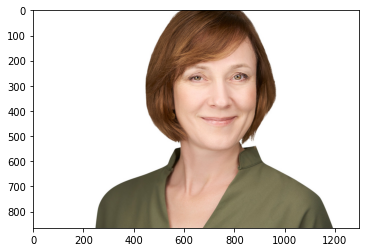

In [ ]:
og = np.asarray(plt.imread(image_path),dtype=np.float64)
og = og/255
og2 = og
plt.imshow(og2)

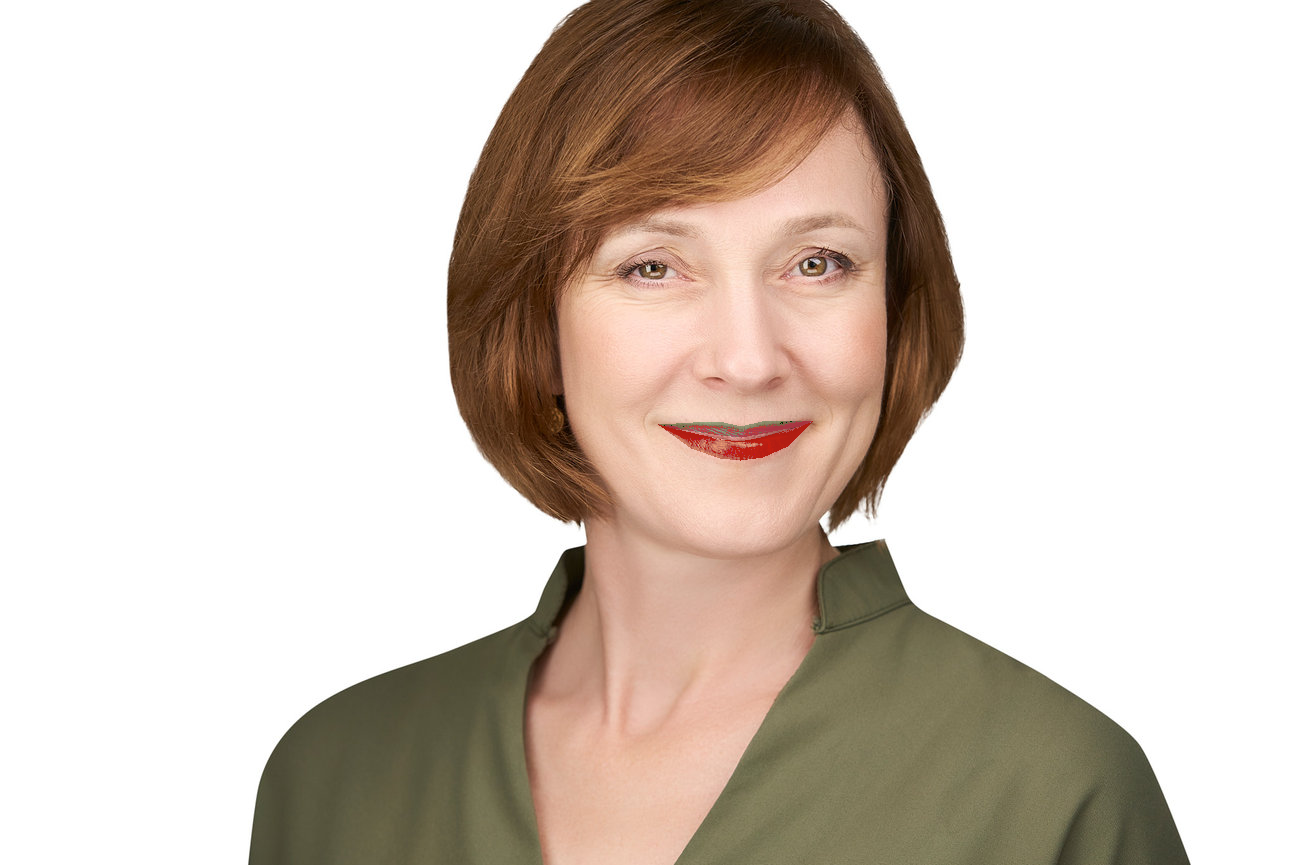

In [ ]:
#BOTH LIPS
from PIL import Image
import numpy as np
from skimage import img_as_ubyte

cp12= IR_idt12
cp13 = IR_idt13
for x in range(IR_idt12.shape[0]):
  for y in range(IR_idt12.shape[1]):
    if (cp12[x,y,3]==1.0):
      og2[x,y,0]=cp12[x,y,0]
      og2[x,y,1]=cp12[x,y,1]
      og2[x,y,2]=cp12[x,y,2]
    if (cp13[x,y,3]==1.0):
      og2[x,y,0]=cp13[x,y,0]
      og2[x,y,1]=cp13[x,y,1]
      og2[x,y,2]=cp13[x,y,2]


img = img_as_ubyte(og2/np.max(og2))
img1213= Image.fromarray(img)
img1213

## hist

In [ ]:
import os
os.listdir()

['t1.jpg',
 'facetools',
 'face-parsing.PyTorch',
 'colour_transfer',
 '=2.0.1',
 'fcn_pytorch.ipynb',
 'segmented face',
 'original face',
 'face_makeup_PyTorch',
 'result',
 'FYP Interim Report.gdoc',
 'girl15.csv',
 'out.png',
 'girl21.csv',
 'girl_3.csv',
 'girl.csv',
 'Full.ipynb',
 'source',
 'target',
 'result_one_dimensional',
 'result_N_dimensional',
 'FYP REPORT',
 'report',
 'Hair Color Transfer Unsegmented.ipynb',
 'Final Colour Transfer.ipynb',
 'output2.png',
 'result_lips',
 'original face OpenFace',
 'result_eyebrows',
 'result_eyes',
 'results_skin',
 'result_face',
 'chapter4.drawio',
 'Lips Color Transfer Unsegmented.ipynb']

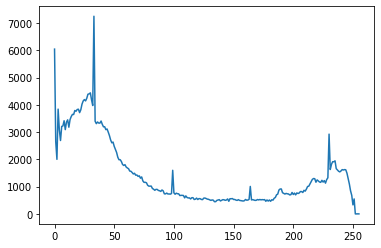

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl9_132_result1213_hist.jpg")

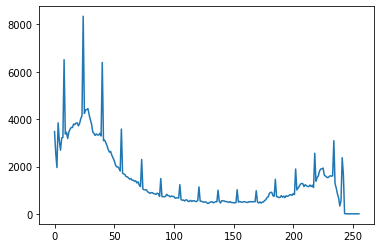

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl9_13_result1213_hist.jpg")

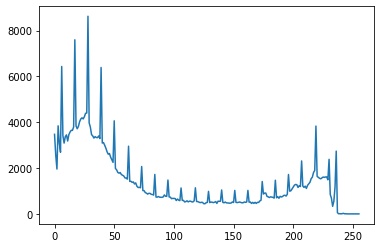

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl19_13_result1213_hist.jpg")

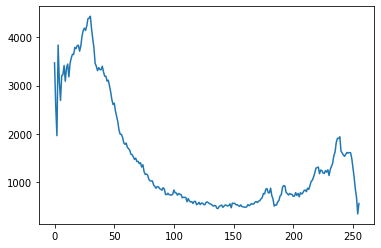

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl14_13_result1213_hist.jpg")

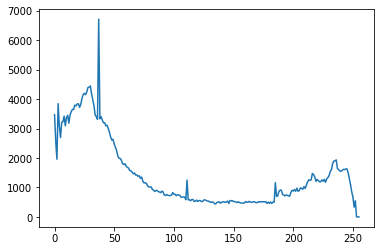

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/11_13_result1213_hist.jpg")

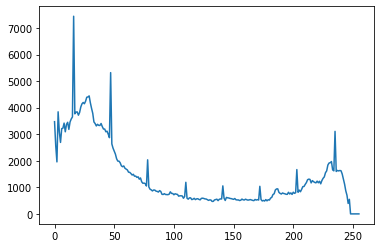

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/7_13_result1213_hist.jpg")

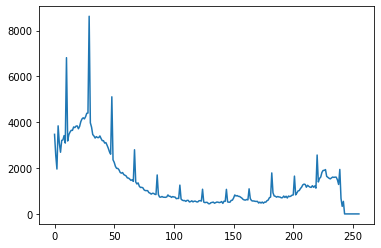

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/17_13_result1213_hist.jpg")

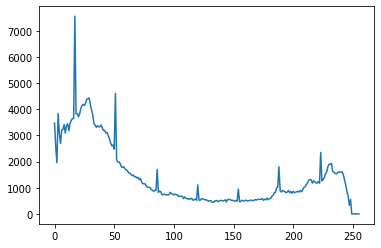

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/1_13_result1213_hist.jpg")

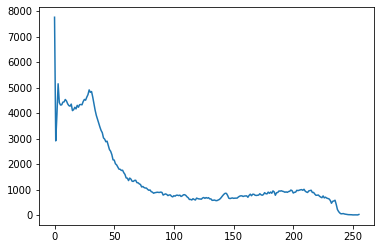

In [ ]:
og_hist = cv2.imread(image_path,0) 
histr = cv2.calcHist([og_hist],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl13_hist.jpg")

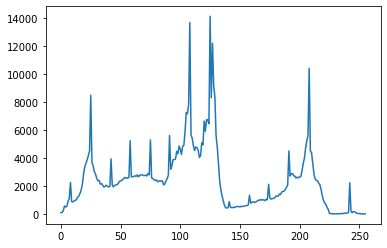

In [ ]:

histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/13_hist.jpg")

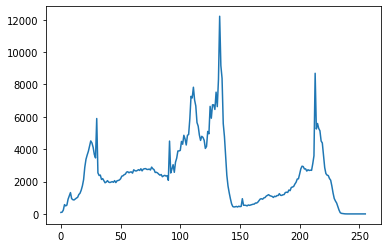

In [ ]:
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/17_girl21_result1213_hist.jpg")

In [ ]:
og_hist = cv2.imread(image_path,0) 

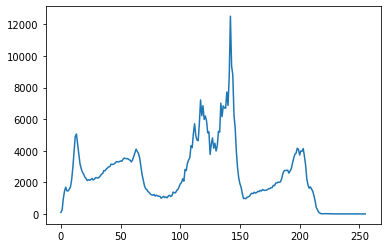

In [ ]:
histr = cv2.calcHist([og_hist],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl21_hist.jpg")

In [ ]:
image_path = "result_lips/openface/girl16_girl21_result2_1213.jpg"

In [ ]:
og_hist = cv2.imread(image_path,0) 

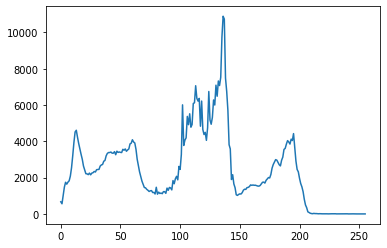

In [ ]:
histr = cv2.calcHist([og_hist],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#plt.savefig("result_lips/openface/girl21_hist.jpg")

In [ ]:
image_path = "original face/image/17.png"

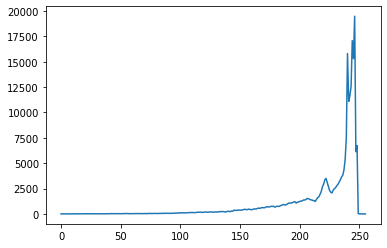

In [ ]:
histr = cv2.calcHist([og_hist],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#16.jpg

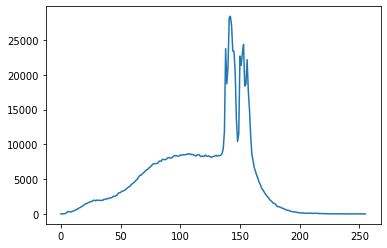

In [ ]:
histr = cv2.calcHist([og_hist],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 
#17.png

## Result Saving

## 16

In [ ]:
img1213.save("result_lips/openface/11_16_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl_2_16_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl18_16_result2_1213.jpg")

## girl21

In [ ]:
import os
os.getcwd()

'/content/gdrive/My Drive/FYP'

In [ ]:
img1213.save("result_lips/openface/girl18_girl21_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/11_girl21_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl_2_girl21_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/17_girl21_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl8_girl21_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl16_girl21_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/11_girl_3_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/1_girl_3_result3_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl_2_girl_3_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/1_girl21_result2_1213.jpg")

In [ ]:
image_path_target

'original face/girl19.jpg'

## 13

In [ ]:
img1213.save("result_lips/openface/girl18_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/11_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl_2_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/17_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl14_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl19_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl17_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/7_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/1_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl9_13_result2_1213.jpg")

In [ ]:
img1213.save("result_lips/openface/girl18_girl_3_result2_1213.jpg")